In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
awsaf49_coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'coco-2017-dataset' dataset.
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000421447.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000368349.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000520456.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000213124.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000116521.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000319443.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000481895.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000564283.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000266502.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000117064.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000207481.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000237501.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000023743.jpg
/kaggle/input/coco-2017-dataset/coco2017/train2017/000000548836.j

📦 Installing Ultralytics YOLO...
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Object Detection using YOLOv8

🎯 YOLO Object Detection - Multiple Options

Option 1: Running demo with pretrained COCO weights...

Demo: Pretrained COCO Object Detection

📥 Loading YOLOv8n pretrained model...
----------------------------------------------------------------------
✓ Model loaded: yolov8n.pt
✓ Model type: YOLOv8n

📋 Model Information:
----------------------------------------------------------------------
YOLOv8n summary: 129 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs

📥 Downloading sample images for demo...

🔍 Running detection on sample images...

🔍 Running Predictions...
---------------------------------------------------

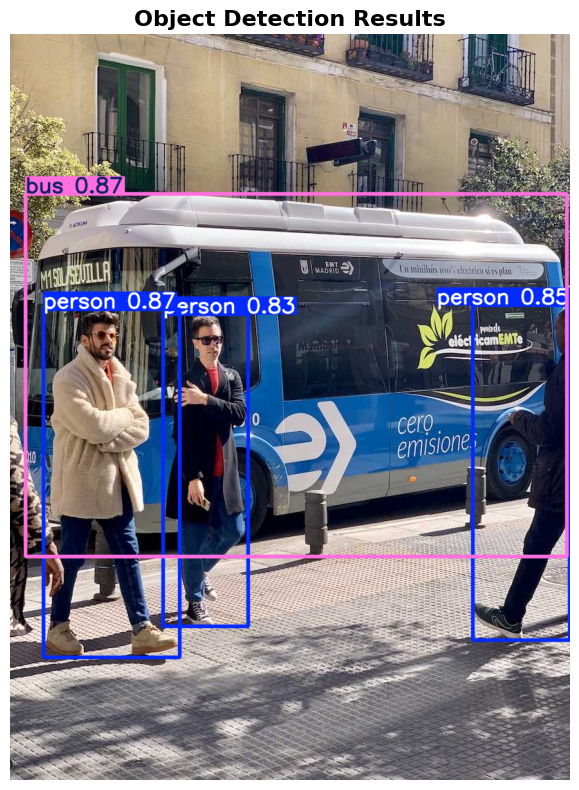


✓ Detected Objects:
   • bus: 0.87
   • person: 0.87
   • person: 0.85
   • person: 0.83

✓ Demo completed!

✅ All Done!


In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import shutil
from tqdm import tqdm
import yaml

# Install ultralytics (YOLOv8) if not already installed
try:
    from ultralytics import YOLO
    print("✓ Ultralytics YOLO already installed")
except ImportError:
    print("📦 Installing Ultralytics YOLO...")
    os.system('pip install ultralytics -q')
    from ultralytics import YOLO

print("=" * 70)
print("Object Detection using YOLOv8")
print("=" * 70)

class YOLOObjectDetector:
    def __init__(self, model_size='n'):
        """
        Initialize YOLO detector
        model_size: 'n' (nano), 's' (small), 'm' (medium), 'l' (large), 'x' (xlarge)
        """
        self.model_size = model_size
        self.model = None
        self.results = None
        self.class_names = None

    def load_pretrained_model(self):
        """Load pretrained YOLOv8 model"""
        print(f"\n📥 Loading YOLOv8{self.model_size} pretrained model...")
        print("-" * 70)

        model_name = f'yolov8{self.model_size}.pt'
        self.model = YOLO(model_name)

        print(f"✓ Model loaded: {model_name}")
        print(f"✓ Model type: YOLOv8{self.model_size}")

        return self.model

    def explore_dataset(self, base_path):
        """Explore COCO dataset structure"""
        print("\n📂 Exploring Dataset Structure...")
        print("-" * 70)

        # Common paths for COCO dataset
        possible_paths = [
            base_path,
            os.path.join(base_path, 'coco'),
            os.path.join(base_path, 'data'),
        ]

        for path in possible_paths:
            if os.path.exists(path):
                print(f"✓ Found dataset at: {path}")

                # List contents
                contents = os.listdir(path)
                print(f"\nDataset contents:")
                for item in contents[:10]:  # Show first 10 items
                    item_path = os.path.join(path, item)
                    if os.path.isdir(item_path):
                        print(f"  📁 {item}/")
                    else:
                        print(f"  📄 {item}")

                return path

        print("⚠️ Dataset structure not found in expected locations")
        return base_path

    def prepare_coco_dataset(self, dataset_path):
        """Prepare COCO dataset for YOLO training"""
        print("\n🔧 Preparing Dataset for YOLO...")
        print("-" * 70)

        # Check for common COCO structure
        train_images = os.path.join(dataset_path, 'train2017')
        val_images = os.path.join(dataset_path, 'val2017')

        if os.path.exists(train_images):
            print(f"✓ Found training images: {len(os.listdir(train_images))} images")
        if os.path.exists(val_images):
            print(f"✓ Found validation images: {len(os.listdir(val_images))} images")

        # For this example, we'll use pretrained COCO weights
        print("\n📝 Note: Using pretrained COCO weights (80 classes)")
        print("   If you want custom training, prepare dataset in YOLO format")

        return train_images, val_images

    def train_model(self, data_yaml_path=None, epochs=50, imgsz=640):
        """
        Train YOLO model on custom dataset
        If data_yaml_path is None, skip training and use pretrained weights
        """
        if data_yaml_path and os.path.exists(data_yaml_path):
            print("\n🚀 Starting Training...")
            print("-" * 70)

            # Train the model
            self.results = self.model.train(
                data=data_yaml_path,
                epochs=epochs,
                imgsz=imgsz,
                batch=16,
                device='0',  # Use GPU 0
                patience=10,
                save=True,
                plots=True,
                verbose=True
            )

            print("\n✓ Training completed!")
        else:
            print("\n📝 Skipping training - using pretrained weights")
            print("   To train on custom data, provide data.yaml file")

    def validate_model(self, data_yaml_path=None):
        """Validate model performance"""
        if data_yaml_path and os.path.exists(data_yaml_path):
            print("\n📊 Validating Model...")
            print("-" * 70)

            metrics = self.model.val(data=data_yaml_path)

            print(f"\n✓ Validation Results:")
            print(f"   mAP50: {metrics.box.map50:.4f}")
            print(f"   mAP50-95: {metrics.box.map:.4f}")

            return metrics
        else:
            print("\n📝 Validation requires data.yaml file")
            return None

    def predict_on_images(self, image_source, conf_threshold=0.25, save_dir='yolo_predictions'):
        """
        Run predictions on images
        image_source: can be image path, folder path, or video path
        """
        print(f"\n🔍 Running Predictions...")
        print("-" * 70)

        # Create output directory
        os.makedirs(save_dir, exist_ok=True)

        # Run inference
        results = self.model.predict(
            source=image_source,
            conf=conf_threshold,
            save=True,
            project=save_dir,
            name='detect',
            exist_ok=True
        )

        print(f"✓ Predictions saved to: {save_dir}/detect/")

        return results

    def predict_on_sample_images(self, image_folder, num_samples=6, conf_threshold=0.25):
        """Predict on random sample images and visualize"""
        print(f"\n🎨 Running predictions on {num_samples} sample images...")
        print("-" * 70)

        # Get image files
        image_files = [f for f in os.listdir(image_folder)
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        if len(image_files) == 0:
            print("⚠️ No images found in folder!")
            return

        # Random sample
        sample_files = np.random.choice(image_files,
                                       min(num_samples, len(image_files)),
                                       replace=False)

        # Create figure
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()

        for idx, image_file in enumerate(sample_files):
            image_path = os.path.join(image_folder, image_file)

            # Run prediction
            results = self.model.predict(source=image_path, conf=conf_threshold, verbose=False)

            # Get annotated image
            annotated_img = results[0].plot()

            # Convert BGR to RGB
            annotated_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

            # Plot
            axes[idx].imshow(annotated_img)
            axes[idx].axis('off')
            axes[idx].set_title(f'Image: {image_file}', fontsize=10)

        plt.tight_layout()
        os.makedirs('yolo_results', exist_ok=True)
        plt.savefig('yolo_results/sample_detections.png', dpi=100, bbox_inches='tight')
        plt.show()

        print("✓ Sample predictions visualized")

    def analyze_predictions(self, results):
        """Analyze and visualize prediction statistics"""
        print("\n📈 Analyzing Predictions...")
        print("-" * 70)

        all_classes = []
        all_confidences = []

        for result in results:
            if len(result.boxes) > 0:
                classes = result.boxes.cls.cpu().numpy()
                confidences = result.boxes.conf.cpu().numpy()

                all_classes.extend(classes)
                all_confidences.extend(confidences)

        if len(all_classes) == 0:
            print("⚠️ No detections found!")
            return

        # Get class names
        class_names = result.names

        # Count detections per class
        unique_classes, counts = np.unique(all_classes, return_counts=True)

        print(f"\n✓ Total detections: {len(all_classes)}")
        print(f"✓ Unique classes detected: {len(unique_classes)}")
        print(f"✓ Average confidence: {np.mean(all_confidences):.2f}")

        # Visualize class distribution
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Bar plot - top 10 classes
        top_indices = np.argsort(counts)[-10:][::-1]
        top_classes = unique_classes[top_indices]
        top_counts = counts[top_indices]

        class_labels = [class_names[int(c)] for c in top_classes]

        axes[0].barh(class_labels, top_counts, color='skyblue')
        axes[0].set_xlabel('Count', fontsize=12)
        axes[0].set_title('Top 10 Detected Classes', fontsize=14, fontweight='bold')
        axes[0].grid(axis='x', alpha=0.3)

        # Confidence distribution
        axes[1].hist(all_confidences, bins=30, color='coral', edgecolor='black', alpha=0.7)
        axes[1].set_xlabel('Confidence Score', fontsize=12)
        axes[1].set_ylabel('Frequency', fontsize=12)
        axes[1].set_title('Confidence Score Distribution', fontsize=14, fontweight='bold')
        axes[1].grid(axis='y', alpha=0.3)

        plt.tight_layout()
        os.makedirs('yolo_results', exist_ok=True)
        plt.savefig('yolo_results/detection_analysis.png', dpi=100, bbox_inches='tight')
        plt.show()

    def detect_on_video(self, video_path, output_path='output_video.mp4', conf_threshold=0.25):
        """Run detection on video file"""
        print(f"\n🎬 Running detection on video...")
        print("-" * 70)

        # Run inference on video
        results = self.model.predict(
            source=video_path,
            conf=conf_threshold,
            save=True,
            project='yolo_results',
            name='video_detect',
            exist_ok=True
        )

        print(f"✓ Video saved to: yolo_results/video_detect/")

        return results

    def export_model(self, format='onnx'):
        """Export model to different formats"""
        print(f"\n📦 Exporting model to {format.upper()}...")
        print("-" * 70)

        self.model.export(format=format)

        print(f"✓ Model exported to {format.upper()} format")

    def get_model_info(self):
        """Display model information"""
        print("\n📋 Model Information:")
        print("-" * 70)

        info = self.model.info(verbose=True)

        return info

# Utility Functions
def create_sample_yaml():
    """Create a sample data.yaml for custom training"""
    yaml_content = """
# Dataset configuration for YOLO training
path: /kaggle/input/your-dataset  # dataset root dir
train: train/images  # train images (relative to 'path')
val: val/images  # val images (relative to 'path')
test: test/images  # test images (optional)

# Classes
names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  # Add your classes here...
"""

    with open('data.yaml', 'w') as f:
        f.write(yaml_content)

    print("✓ Sample data.yaml created")
    print("  Edit this file to match your dataset structure")

# Main Execution Functions
def demo_pretrained_detection():
    """Demo: Object detection with pretrained COCO weights"""
    print("\n" + "=" * 70)
    print("Demo: Pretrained COCO Object Detection")
    print("=" * 70)

    # Initialize detector with nano model (fastest)
    detector = YOLOObjectDetector(model_size='n')

    # Load pretrained model
    model = detector.load_pretrained_model()

    # Display model info
    detector.get_model_info()

    # For demo purposes - download sample images
    print("\n📥 Downloading sample images for demo...")
    os.system('wget -q https://ultralytics.com/images/bus.jpg -O sample_bus.jpg')
    os.system('wget -q https://ultralytics.com/images/zidane.jpg -O sample_people.jpg')

    # Predict on sample images
    print("\n🔍 Running detection on sample images...")
    results = detector.predict_on_images('sample_bus.jpg', conf_threshold=0.3)

    # Visualize results
    if results and len(results) > 0:
        result = results[0]
        annotated = result.plot()
        annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 8))
        plt.imshow(annotated_rgb)
        plt.axis('off')
        plt.title('Object Detection Results', fontsize=16, fontweight='bold')
        plt.tight_layout()
        os.makedirs('yolo_results', exist_ok=True)
        plt.savefig('yolo_results/demo_detection.png', dpi=100, bbox_inches='tight')
        plt.show()

        # Print detections
        print("\n✓ Detected Objects:")
        for box in result.boxes:
            class_id = int(box.cls[0])
            confidence = float(box.conf[0])
            class_name = result.names[class_id]
            print(f"   • {class_name}: {confidence:.2f}")

    print("\n✓ Demo completed!")
    return detector

def train_on_custom_dataset(dataset_path, model_size='n', epochs=50):
    """Train YOLO on custom dataset"""
    print("\n" + "=" * 70)
    print("Training YOLO on Custom Dataset")
    print("=" * 70)

    # Initialize detector
    detector = YOLOObjectDetector(model_size=model_size)

    # Load pretrained model
    detector.load_pretrained_model()

    # Explore dataset
    detector.explore_dataset(dataset_path)

    # Create sample yaml (user should edit this)
    create_sample_yaml()

    print("\n📝 Important: Edit 'data.yaml' to match your dataset!")
    print("   Then run: detector.train_model('data.yaml', epochs=50)")

    return detector

def detect_on_kaggle_dataset(dataset_path, model_size='n'):
    """Run detection on a Kaggle dataset"""
    print("\n" + "=" * 70)
    print("Object Detection on Kaggle Dataset")
    print("=" * 70)

    # Initialize detector
    detector = YOLOObjectDetector(model_size=model_size)

    # Load pretrained model
    detector.load_pretrained_model()

    # Explore dataset
    actual_path = detector.explore_dataset(dataset_path)

    # Find images folder
    image_folders = ['images', 'train', 'val', 'test', 'train2017', 'val2017']
    image_folder = None

    for folder in image_folders:
        test_path = os.path.join(actual_path, folder)
        if os.path.exists(test_path):
            image_folder = test_path
            print(f"\n✓ Using images from: {image_folder}")
            break

    if image_folder is None:
        # Use base path
        image_folder = actual_path

    # Run predictions on sample images
    detector.predict_on_sample_images(image_folder, num_samples=6, conf_threshold=0.25)

    # Run predictions on all images
    results = detector.predict_on_images(image_folder, conf_threshold=0.25)

    # Analyze predictions
    if results:
        detector.analyze_predictions(results)

    print("\n✓ Detection completed!")
    print("📁 Check 'yolo_results' and 'yolo_predictions' folders")

    return detector

# Main execution
if __name__ == "__main__":
    print("\n🎯 YOLO Object Detection - Multiple Options\n")

    # Option 1: Demo with pretrained weights (no dataset needed)
    print("Option 1: Running demo with pretrained COCO weights...")
    detector = demo_pretrained_detection()

    #Option 2: Detect on Kaggle dataset
    #Uncomment and update path:
    #DATASET_PATH = '/kaggle/input/coco-2017-dataset/coco2017/test2017.jpg'
    #detector = detect_on_kaggle_dataset(DATASET_PATH, model_size='n')

    # Option 3: Train on custom dataset
    # Uncomment and update path:
    #DATASET_PATH = '/kaggle/input/coco-2017-dataset/coco2017'
    #detector = train_on_custom_dataset(DATASET_PATH, model_size='n', epochs=10)

    print("\n" + "=" * 70)
    print("✅ All Done!")
    print("=" * 70)